In [1]:
### RUN EVERY TIME: COMTRADE DATASETS EXTRACTING

In [51]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
import gc
import os
import datetime
import time
import requests
import json ### To correct JSON structure before unpacking
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [4]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2022-12-31'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Checked EBOPS service IDs list (df_serv_to_gics['GICS Group Code']):
list_services = ['206', '210', '214', '218', '219', '223', '227', '231', '232', '237', '240', '246', '247', '250', '251', '254', '255', '256', '257', '258', '263',
                 '264', '269', '272', '273', '288', '289', '292', '293', '294', '310', '391', '431', '500', '888', '891', '892', '894', '950']
### Augmented bilateral export:
str_path_export_bilateral = 'Data_Files/Source_Files/comtrade_export_bilateral.h5'
### Export key:
str_key_unc_export = 'export_augmented'
### Export Quality Index:
str_path_imf_quality = 'Data_Files/Source_Files/imf_export_quality.h5'
### Export key:
str_key_imf_eq = 'export_quality'
### Trade Value Index:
str_path_imf_trade = 'Data_Files/Source_Files/imf_trade_value.h5'
### Export key:
str_key_imf_trade = 'trade_value'
### HS to SITC Conversion Map:
str_path_commodity_map_xlsx = 'Data_Files/Source_Files/hs_to_sitc.xlsx'
str_page_map = 'HS to SITC'
### Factor file:
str_path_quality_exp = 'Data_Files/Source_Files/comtrade_quality_exp.h5'
str_key_comtrade_factor = 'comtrade_factor'
str_path_factor_xlsx = 'Data_Files/Source_Files/comtrade_factor.xlsx'
str_path_factor_csv = 'Data_Files/Source_Files/comtrade_factor.csv'

In [5]:
### DEFINING WEIGHTED AVERAGE CALCULATOR

def weighted_average(ser_data, ser_weight = None, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if ser_weight is None:
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [6]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = list_na_excel_values, keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [7]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
ser_ison_membership.index.names = ['Date', 'Country']
### ISON Members:
list_ison_countries = sorted(ser_ison_membership.index.get_level_values('Country').unique())
### ISON status for the last available date:
ser_ison_status = ser_ison_membership.loc[ser_ison_membership.index[-1][0]]

In [8]:
### IMF EQ: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
dict_request_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
str_imf_base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
str_imf_dataflow_add = 'DataFlow'
str_imf_datastructure_add = 'DataStructure/'
str_imf_codelist_add = 'CodeList/'
str_imf_dataset_add = 'CompactData/'
int_seconds_to_sleep = 3
int_imf_country_limit = 10

In [9]:
### IMF IFS: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors from IMF Data Service:
request_session.headers.update(dict_request_headers)

In [ ]:
### IMF EQ: DATAFLOW SEARCHING

obj_imf_dataflow_list = request_session.get(str_imf_base_url + str_imf_dataflow_add).json()
df_imf_dataflow = pd.DataFrame(obj_imf_dataflow_list['Structure']['Dataflows']['Dataflow'])
df_imf_dataflow = df_imf_dataflow.assign(Description = df_imf_dataflow['Name'].apply(pd.Series)['#text'].values)[['@id', 'Description']]
ser_imf_dataflow = df_imf_dataflow.set_index('@id', drop = True).squeeze()
### Searching DataFlow code for further requests:
str_imf_eq_id = ser_imf_dataflow[ser_imf_dataflow.str.contains('Export Quality')].index[0].replace('DS-', '')
print(str_imf_eq_id)

In [11]:
### IMF EQ: DATASTRUCTURE SEARCHING

obj_imf_eq_structure = request_session.get(str_imf_base_url + str_imf_datastructure_add + str_imf_eq_id).json()
df_imf_eq_params = pd.DataFrame(obj_imf_eq_structure['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension'])\
                                [['@conceptRef', '@codelist', '@isFrequencyDimension']]
### Receiving DataFlow parameters and code lists for each of them:
print(df_imf_eq_params)

  @conceptRef        @codelist @isFrequencyDimension
0        FREQ          CL_FREQ                  true
1    REF_AREA       CL_AREA_EQ                   NaN
2     PRODUCT    CL_PRODUCT_EQ                   NaN
3   INDICATOR  CL_INDICATOR_EQ                   NaN


In [13]:
### IMF EQ: CODES DESCRIPTIONS LOADING

for int_counter, str_param_code in enumerate(df_imf_eq_params['@codelist']):
    if (int_counter == 2):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_eq_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_eq_param =  pd.DataFrame(obj_imf_eq_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_eq_param = df_imf_eq_param.assign(Text = df_imf_eq_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        df_imf_eq_param = df_imf_eq_param.loc[df_imf_eq_param['@value'].str.len() == 2]
#        dict_indicator = dict(zip(df_imf_eq_param['@value'], df_imf_eq_param['Text']))
        list_sitc_codes = sorted(df_imf_eq_param['@value'].values)
        
list_ison_countries = sorted(ser_ison_status.index.to_list())
str_quality_index = 'qual'
str_eq_freq = 'A'

In [ ]:
### IMF EQ: QUALITY INDEX DATA RETRIEVING

gc.collect()
### List of dictionaries for future concatenation:
list_eq_portions = [] 
### Beggining of request URL:
str_eq_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_eq_id + '/' 
str_eq_const_url
### Looping over reporter:
for iter_interval in range(-(-len(list_ison_countries) // int_imf_country_limit) ):
#for iter_country in ['AU']:
    print(str(iter_interval * int_imf_country_limit), ':', str((iter_interval + 1) * int_imf_country_limit))
    list_iter_countries = list_ison_countries[(iter_interval * int_imf_country_limit) : ((iter_interval + 1) * int_imf_country_limit)]
    str_eq_full_url = str_eq_const_url + '.'.join([str_eq_freq, '+'.join(list_iter_countries), '+'.join(list_sitc_codes), str_quality_index]) \
                                       + '?start_period=' + str(date_start.year) + '&end_period=' + str(date_end.year)
    obj_eq_set = request_session.get(str_eq_full_url)
    ### Data reading as JSON and adding to collection:
    list_eq_portions.append(json.loads(obj_eq_set.text.replace('@OBS_STATUS', '@OBS_VALUE')))
#    break

In [82]:
### IMF EQ: QUALITY INDEX DATA PREPARATION AND SAVING

gc.collect()

list_quality_data = []
for dict_iter_response in list_eq_portions:
    for dict_iter_portion in dict_iter_response['CompactData']['DataSet']['Series']:
        if (len(dict_iter_portion['Obs']) > 0):
            str_iter_country = dict_iter_portion['@REF_AREA']
            str_iter_sitc_code = dict_iter_portion['@PRODUCT']
            if isinstance(dict_iter_portion['Obs'], list):
                df_iter_raw = pd.DataFrame(dict_iter_portion['Obs'])
            else:
                df_iter_raw = pd.DataFrame([dict_iter_portion['Obs']])
            df_iter_raw.columns = ['Year', 'Quality']
            df_iter_raw['Date'] = df_iter_raw['Year'].apply(pd.to_datetime) + pd.offsets.BYearEnd()
            df_iter_raw = df_iter_raw.set_index('Date')[['Quality']].astype('float32')
            df_iter_raw = pd.concat({str_iter_country: df_iter_raw}, names = ['Country'])
            df_iter_raw = pd.concat({str_iter_sitc_code: df_iter_raw}, names = ['SITC_ID'])
            list_quality_data.append(df_iter_raw)
#        break
#    break
ser_quality_data = pd.concat(list_quality_data, axis = 0).squeeze().sort_index()
ser_quality_data.to_hdf(path_or_buf = str_path_imf_quality, key = str_key_imf_eq, mode = 'w', format = 'fixed')

In [14]:
### IMF EQ: CODES DESCRIPTIONS LOADING

for int_counter, str_param_code in enumerate(df_imf_eq_params['@codelist']):
    if (int_counter == 2):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_eq_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_eq_param =  pd.DataFrame(obj_imf_eq_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_eq_param = df_imf_eq_param.assign(Text = df_imf_eq_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        df_imf_eq_param = df_imf_eq_param.loc[df_imf_eq_param['@value'].str.len() == 2]
        list_sitc_codes = sorted(df_imf_eq_param['@value'].values)
        
list_ison_countries = sorted(ser_ison_status.index.to_list())
str_value_index = 'value'
str_eq_freq = 'A'

In [ ]:
### IMF EQ: TRADE VALUE DATA RETRIEVING

gc.collect()
### List of dictionaries for future concatenation:
list_eq_portions = [] 
### Beggining of request URL:
str_eq_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_eq_id + '/' 
str_eq_const_url
### Looping over reporter:
for iter_interval in range(-(-len(list_ison_countries) // int_imf_country_limit) ):
#for iter_country in ['AU']:
    print(str(iter_interval * int_imf_country_limit), ':', str((iter_interval + 1) * int_imf_country_limit))
    list_iter_countries = list_ison_countries[(iter_interval * int_imf_country_limit) : ((iter_interval + 1) * int_imf_country_limit)]
    str_eq_full_url = str_eq_const_url + '.'.join([str_eq_freq, '+'.join(list_iter_countries), '+'.join(list_sitc_codes), str_value_index]) \
                                       + '?start_period=' + str(date_start.year) + '&end_period=' + str(date_end.year)
    obj_eq_set = request_session.get(str_eq_full_url)
    ### Data reading as JSON and adding to collection:
    list_eq_portions.append(json.loads(obj_eq_set.text.replace('@OBS_STATUS', '@OBS_VALUE')))
#    break

In [20]:
### IMF EQ: QUALITY INDEX DATA PREPARATION AND SAVING

gc.collect()

list_trade_data = []
for dict_iter_response in list_eq_portions:
    for dict_iter_portion in dict_iter_response['CompactData']['DataSet']['Series']:
        if (len(dict_iter_portion['Obs']) > 0):
            str_iter_country = dict_iter_portion['@REF_AREA']
            str_iter_sitc_code = dict_iter_portion['@PRODUCT']
            if isinstance(dict_iter_portion['Obs'], list):
                df_iter_raw = pd.DataFrame(dict_iter_portion['Obs'])
            else:
                df_iter_raw = pd.DataFrame([dict_iter_portion['Obs']])
            df_iter_raw.columns = ['Year', 'Quality']
            df_iter_raw['Date'] = df_iter_raw['Year'].apply(pd.to_datetime) + pd.offsets.BYearEnd()
            df_iter_raw = df_iter_raw.set_index('Date')[['Quality']].astype('float32')
            df_iter_raw = pd.concat({str_iter_country: df_iter_raw}, names = ['Country'])
            df_iter_raw = pd.concat({str_iter_sitc_code: df_iter_raw}, names = ['SITC_ID'])
            list_trade_data.append(df_iter_raw)
#        break
#    break
ser_trade_data = pd.concat(list_trade_data, axis = 0).squeeze().sort_index()
ser_trade_data.name = 'Trade_Value'
ser_trade_data.to_hdf(path_or_buf = str_path_imf_trade, key = str_key_imf_trade, mode = 'w', format = 'fixed')

In [ ]:
### BILATERAL EXPORT DATA LOADING TO PERFORM FACTOR CALCULATION

gc.collect()
list_export_chunks = []
for num_iter_number, ser_iter_chunk in enumerate(pd.read_hdf(str_path_export_bilateral, key = str_key_unc_export, chunksize = 1000000)):
    gc.collect()
    print(num_iter_number, ': Extraction started')
    ser_iter_chunk = ser_iter_chunk[ser_iter_chunk > 0.0].astype('int32')
    df_iter_chunk = ser_iter_chunk.reset_index()
    df_iter_chunk = df_iter_chunk[(df_iter_chunk['Reporter'] != df_iter_chunk['Partner']) & \
                                  ((df_iter_chunk['Type'] == 'Goods') | df_iter_chunk['Commodity_ID'].isin(list_services)) & (df_iter_chunk['Reporter'] != 'World') & \
                                  (df_iter_chunk['Partner'] != 'World')]\
                               .drop('Type', axis = 1)    
    print(num_iter_number, ': Filtering performed')    
    ser_iter_chunk = df_iter_chunk.set_index(['Date', 'Reporter', 'Partner', 'Commodity_ID']).squeeze().sort_index()
    del df_iter_chunk
    gc.collect()
    list_export_chunks.append(ser_iter_chunk)
    print(num_iter_number, ': Chunk added to container')    
ser_bilateral_export = pd.concat(list_export_chunks, axis = 0, sort = False).sort_index()
ser_bilateral_export.name = 'Export'
del list_export_chunks
gc.collect()

In [10]:
### REPORTER / COMMODITY BY DATE TOTAL EXPORT

### Export totals:
ser_country_comm_export = ser_bilateral_export.groupby(['Date', 'Reporter', 'Commodity_ID']).sum().dropna()
ser_country_comm_export.name = 'Export'

del ser_bilateral_export
gc.collect()

23

In [11]:
### IMF EXPORT TRADE DATA LOADING

gc.collect()

ser_trade_data = pd.read_hdf(path_or_buf = str_path_imf_trade, key = str_key_imf_trade).reorder_levels(['Date', 'Country', 'SITC_ID']).sort_index()
#ser_trade_data = ser_trade_data.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
ser_trade_data = ser_trade_data.drop('ag', axis = 0, level = 'SITC_ID') / 1000
ser_trade_data.name = 'Trade_Value'

In [12]:
### IMF EXPORT QUALITY DATA LOADING

gc.collect()
ser_quality_data = pd.read_hdf(path_or_buf = str_path_imf_quality, key = str_key_imf_eq).reorder_levels(['Date', 'Country', 'SITC_ID']).sort_index()
#ser_quality_data = ser_quality_data.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
ser_quality_data = ser_quality_data.drop('ag', axis = 0, level = 'SITC_ID')

In [13]:
### IMF DATA CONNECTION:

df_quality_data = ser_quality_data.to_frame().join(ser_trade_data)

In [14]:
### IMF TRADE DATA BASED (INTERNAL) INDIVIDUAL EXPORT QUALITY FACTOR CALCULATION

ser_ind_imf_factor = df_quality_data.groupby(['Date', 'Country']).apply(lambda df_group: weighted_average(df_group['Quality'], df_group['Trade_Value'] / 1000))
ser_ind_imf_factor.index.set_names('Reporter', level = 'Country', inplace = True)
ser_ind_imf_factor.name = 'Original'

In [14]:
### HS TO SITC CONVERSION MAP LOADING

df_raw_conversion = pd.read_excel(engine = 'openpyxl', io = str_path_commodity_map_xlsx, sheet_name = str_page_map, header = 0, index_col = None,
                                 na_values = list_na_excel_values, keep_default_na = False, dtype = str)
df_comm_conversion = df_raw_conversion.set_index('Commodity ID')[['SITC Correspondent 1', 'SITC Correspondent 2', 'SITC Correspondent 3']]
ser_comm_conversion = df_comm_conversion.stack().droplevel(-1)
ser_comm_conversion.index.names = ['Commodity_ID']
ser_comm_conversion.name = 'SITC_ID'

In [15]:
### CONVERTING FROM SITC CLASSIFICATION TO HS CLASSIFICATION AND ADDING COMTRADE EXPORT FLOWS

gc.collect()

def conditional_average(df_group):
    if (len(df_group) > 1):
        flo_result = weighted_average(df_group['Quality'], df_group['Trade_Value'])
    else:
        flo_result = df_group['Quality'].values[0]
    return flo_result

### Adding mapping table:
df_quality_comtrade = df_quality_data.join(ser_comm_conversion.to_frame().set_index('SITC_ID', append = True)).reset_index('Commodity_ID')\
                                     .dropna(subset = ['Commodity_ID']).set_index(['Commodity_ID'], append = True)\
                                     .reorder_levels(['Date', 'Country', 'Commodity_ID', 'SITC_ID']).sort_index()
### Performoing weighted average for "n -> 1" conversions:
df_quality_comtrade = df_quality_comtrade.groupby(['Date', 'Country', 'Commodity_ID']).apply(conditional_average).to_frame()
df_quality_comtrade.index.set_names('Reporter', level = 'Country', inplace = True)
df_quality_comtrade.columns = ['Quality']
### Adding ComTrade Export flows:
df_quality_comtrade = df_quality_comtrade.join(ser_country_comm_export, how = 'right').dropna(subset = ['Export'])
### Adding regional connections:
ser_ison_status.index.name = 'Reporter'
df_quality_comtrade = df_quality_comtrade.join(ser_ison_status).dropna(subset = ['Market']).set_index('Market', append = True)
ser_ison_status.index.name = 'Country'

In [16]:
### FILLING QUALITY GAPS

gc.collect()

### Forwarding Quality to expand 2014 values till the end of vector:
df_quality_comtrade['Quality_Ind'] = df_quality_comtrade['Quality'].groupby(['Reporter', 'Commodity_ID', 'Market']).ffill()
### Calculating of Regional Quality:
ser_market_mean = df_quality_comtrade.groupby(['Date', 'Commodity_ID', 'Market'])\
                                     .apply(lambda df_group: weighted_average(df_group['Quality'], df_group['Export'] / 1000))\
                                     .groupby(['Commodity_ID', 'Market']).ffill()
ser_market_mean.name = 'Quality_Market'
### Calculating of Universe Quality:
ser_ison_mean = df_quality_comtrade.groupby(['Date', 'Commodity_ID'])\
                                     .apply(lambda df_group: weighted_average(df_group['Quality'], df_group['Export'] / 1000))\
                                     .groupby('Commodity_ID').ffill()
ser_ison_mean.name = 'Quality_ISON'
### Joining aggregated Quality values to main dataset:
df_quality_comtrade = df_quality_comtrade.join(ser_market_mean).join(ser_ison_mean)
### Forwarding aggregated Quality to expand 2014 values till the end of vector:
df_quality_comtrade[['Quality_Market', 'Quality_ISON']] = \
                                    df_quality_comtrade[['Quality_Market', 'Quality_ISON']].groupby(['Commodity_ID', 'Reporter']).ffill()
### Using Quality Market values to fill Individual Quality for new commodity types:
df_quality_comtrade['Quality_Ind_M'] = df_quality_comtrade['Quality_Ind'].combine_first(df_quality_comtrade['Quality_Market'])
df_quality_comtrade['Quality_Ind_W'] = df_quality_comtrade['Quality_Ind'].combine_first(df_quality_comtrade['Quality_ISON'])

In [33]:
### TEST: LOADING COMMODITIES TO INDUSTRIES MAP

### Commodity to industry connection:
str_path_industry_map_xlsx = 'Data_Files/Source_Files/goods_to_industries_hs.xlsx'
str_page_services = 'EBOPS'
str_page_goods = 'AG2'

df_goods_to_ind = pd.read_excel(engine = 'openpyxl', io = str_path_industry_map_xlsx, sheet_name = str_page_goods, header = 0, dtype = 'object',
                                na_values = list_na_excel_values, keep_default_na = False).set_index('Commodity ID')
df_goods_to_ind.index.names = ['Commodity_ID']
ser_goods_to_ind = df_goods_to_ind.dropna()['GICS Industry Group'].squeeze()
ser_goods_to_ind.name = 'Industry_Group'
df_services_to_ind = pd.read_excel(engine = 'openpyxl', io = str_path_industry_map_xlsx, sheet_name = str_page_services, header = 0, dtype = 'object',
                                na_values = list_na_excel_values, keep_default_na = False).set_index('Service ID')
df_services_to_ind.index.names = ['Commodity_ID']
ser_comm_description = pd.concat([df_goods_to_ind['AG2'], df_services_to_ind.loc[list_services, 'Service Description']], axis = 0)
ser_comm_description.name = 'Description'

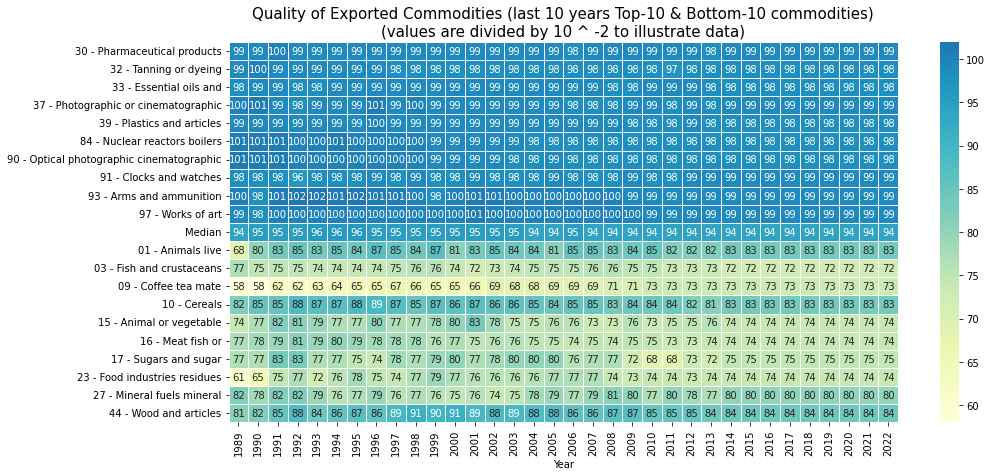

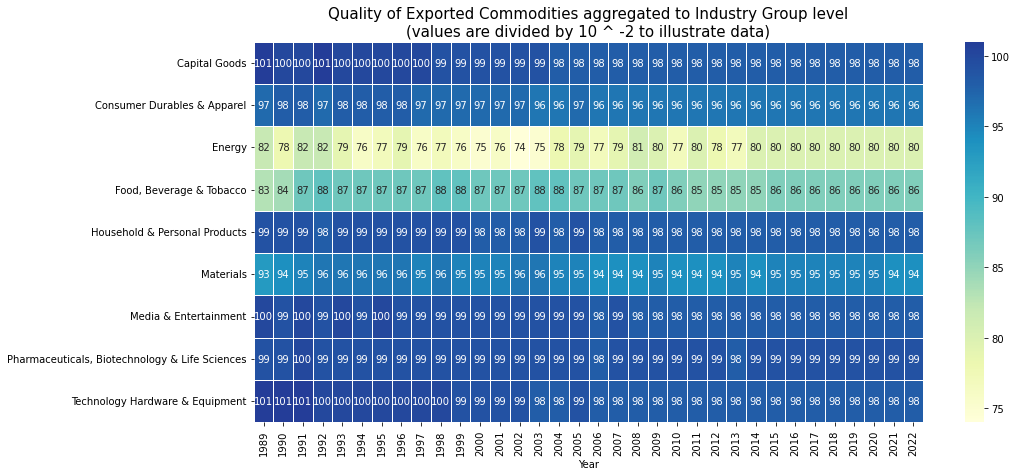

In [83]:
### TEST: QUALITY VISUALIZATION

str_test_date = '2020-12-31'
int_n_years = 10
int_n_commodities = 10

### Commodities quality:
ser_ison_sorted = ser_ison_mean.loc[ser_ison_mean.index.levels[0][-int_n_years : ]].groupby('Commodity_ID').mean().dropna().sort_values(ascending = False)
### Leaders data preparation:
df_ison_largest = ser_ison_mean.loc[All, ser_ison_sorted[: int_n_commodities].index, All].reset_index()
df_ison_largest['Year'] = df_ison_largest['Date'].dt.year
df_ison_largest['Commodity_Name'] = df_ison_largest['Commodity_ID'].replace(ser_comm_description).str.replace(';', '').str.replace(',', '')
df_ison_largest['Commodity_Name'] = df_ison_largest['Commodity_Name'].str.split(' ').str[: 5].str.join(' ')
df_ison_largest = df_ison_largest.drop(['Date', 'Commodity_ID'], axis = 1).set_index(['Commodity_Name', 'Year']).unstack('Year').sort_index()
### Outsiders data preparation:
df_ison_smallest = ser_ison_mean.loc[All, ser_ison_sorted[-int_n_commodities :].index, All].reset_index()
df_ison_smallest['Year'] = df_ison_smallest['Date'].dt.year
df_ison_smallest['Commodity_Name'] = df_ison_smallest['Commodity_ID'].replace(ser_comm_description).str.replace(';', '').str.replace(',', '')
df_ison_smallest['Commodity_Name'] = df_ison_smallest['Commodity_Name'].str.split(' ').str[: 5].str.join(' ')
df_ison_smallest = df_ison_smallest.drop(['Date', 'Commodity_ID'], axis = 1).set_index(['Commodity_Name', 'Year']).unstack('Year').sort_index()
### Median timeseries:
ser_ison_median = ser_ison_mean.groupby('Date').median()
df_ison_median = pd.concat({'Median': ser_ison_median}, names = ['Commodity_Name']).swaplevel().reset_index()
df_ison_median['Year'] = df_ison_median['Date'].dt.year
df_ison_median = df_ison_median.drop('Date', axis = 1).set_index(['Commodity_Name', 'Year']).unstack('Year').sort_index()    
### Data aggregation:
df_to_plot = pd.concat([df_ison_largest, df_ison_median, df_ison_smallest], axis = 0)
df_to_plot.columns = df_to_plot.columns.droplevel(0)     
df_to_plot.index.name = ''
df_to_plot = (df_to_plot * 100).astype(int)   
int_digits = -2
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False,
                         annot = True, fmt = '0.0f', center = 90)
ax_heatmap.set_title('Quality of Exported Commodities (last ' + str(int_n_years) + ' years Top-' + \
                     str(int_n_commodities) + ' & Bottom-' + str(int_n_commodities) + ' commodities)' + \
                    '\n' + '(values are divided by 10 ^ ' + str(int_digits) + ' to illustrate data)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()      

### Industry Groups quality:
df_ison_quality = df_quality_comtrade['Export'].groupby(['Date', 'Commodity_ID']).sum().to_frame().join(ser_ison_mean)\
                                               .join(ser_goods_to_ind).set_index('Industry_Group', append = True)
df_industry_quality = df_ison_quality.groupby(['Date', 'Industry_Group'])\
                                      .apply(lambda df_group: weighted_average(df_group['Quality_ISON'], df_group['Export'] / 1000)).reset_index()
df_industry_quality['Year'] = df_industry_quality['Date'].dt.year
df_to_plot = df_industry_quality.drop('Date', axis = 1).set_index(['Year', 'Industry_Group']).unstack('Year').sort_index()  
df_to_plot.columns = df_to_plot.columns.droplevel(0)     
df_to_plot.index.name = ''
df_to_plot = (df_to_plot * 100).astype(int)
int_digits = -2
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False,
                         annot = True, fmt = '0.0f', center = 90)
ax_heatmap.set_title('Quality of Exported Commodities aggregated to Industry Group level' + \
                    '\n' + '(values are divided by 10 ^ ' + str(int_digits) + ' to illustrate data)' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()     

In [16]:
### COMTRADE TRADE DATA BASED INDIVIDUAL EXPORT QUALITY FACTOR CALCULATION

ser_ind_m_un_factor = df_quality_comtrade.groupby(['Date', 'Reporter']).apply(lambda df_group: weighted_average(df_group['Quality_Ind_M'], df_group['Export'] / 1000))
ser_ind_m_un_factor.name = 'Alt_M'
ser_ind_w_un_factor = df_quality_comtrade.groupby(['Date', 'Reporter']).apply(lambda df_group: weighted_average(df_group['Quality_Ind_W'], df_group['Export'] / 1000))
ser_ind_w_un_factor.name = 'Alt_W'
ser_market_un_factor = df_quality_comtrade.groupby(['Date', 'Reporter'])\
                                          .apply(lambda df_group: weighted_average(df_group['Quality_Market'], df_group['Export'] / 1000))
ser_market_un_factor.name = 'Product_Lvl_M'
ser_ison_un_factor = df_quality_comtrade.groupby(['Date', 'Reporter'])\
                                        .apply(lambda df_group: weighted_average(df_group['Quality_ISON'], df_group['Export'] / 1000))
ser_ison_un_factor.name = 'Product_Lvl_W'

In [61]:
### TESTING: INDIVIDUAL IMF TRADE DATA VASED AND UN TRADE DATA BASED FACTORS CORRELATION

df_quality_factors = pd.concat([ser_ind_imf_factor, ser_ind_m_un_factor, ser_ind_w_un_factor, ser_market_un_factor, ser_ison_un_factor], axis = 1)[date_start :]

<AxesSubplot:xlabel='Date'>

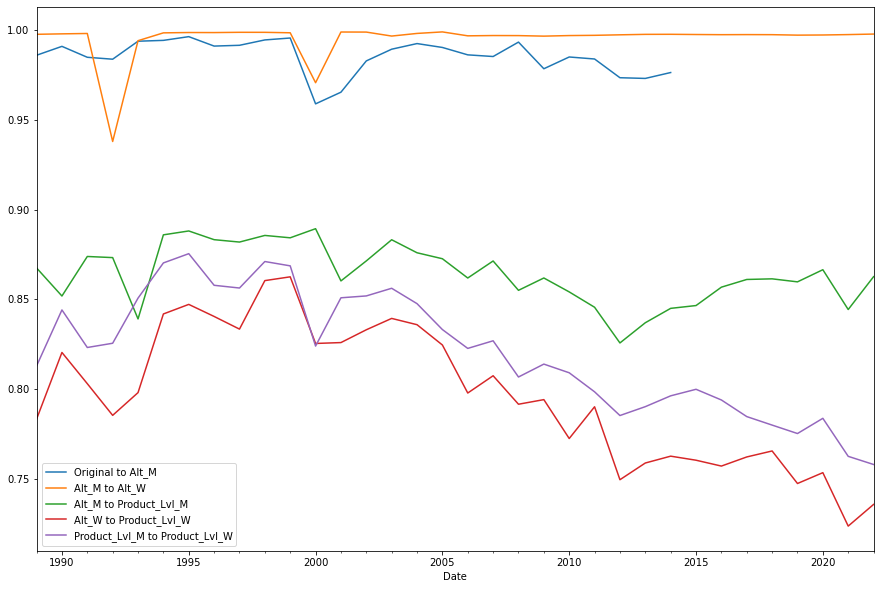

In [64]:
### TEMP

df_quality_corr_full = df_quality_factors.groupby('Date').corr()
df_quality_corr_pairs = pd.DataFrame()
df_quality_corr_pairs[['Original to Alt_M', 'Original to Alt_W']] = df_quality_corr_full.loc[(All, 'Original'), ['Alt_M', 'Alt_W']].droplevel(1)
df_quality_corr_pairs[['Alt_M to Alt_W', 'Alt_M to Product_Lvl_M', 'Alt_M to Product_Lvl_W']] = \
                df_quality_corr_full.loc[(All, 'Alt_M'), ['Alt_W', 'Product_Lvl_M', 'Product_Lvl_W']].droplevel(1)
df_quality_corr_pairs[['Alt_W to Product_Lvl_M', 'Alt_W to Product_Lvl_W']] = \
                df_quality_corr_full.loc[(All, 'Alt_W'), ['Product_Lvl_M', 'Product_Lvl_W']].droplevel(1)
df_quality_corr_pairs['Product_Lvl_M to Product_Lvl_W'] = \
                df_quality_corr_full.loc[(All, 'Product_Lvl_M'), 'Product_Lvl_W'].droplevel(1)
#df_quality_corr_pairs.plot()
df_quality_corr_pairs[['Original to Alt_M', 'Alt_M to Alt_W', 'Alt_M to Product_Lvl_M', 'Alt_W to Product_Lvl_W', 'Product_Lvl_M to Product_Lvl_W']]\
                                                                                                    .plot(figsize = (15, 10))

In [65]:
### QUALITY FACTORS RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(df_group):
    df_result = df_group.droplevel(['Reporter']).reindex(pd.date_range(df_group.index[0][0], str_date_end, freq = 'BY'))
    df_result = df_result.resample('BM').ffill()
    return df_result
df_factor_monthly = df_quality_factors.groupby('Reporter').apply(reindex_monthly).swaplevel()
df_factor_monthly.index.names = ['Date', 'Reporter']

In [66]:
### FACTOR SAVING

df_factor_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
df_factor_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
df_factor_monthly.to_hdf(str_path_quality_exp, str_key_comtrade_factor)